In [112]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [113]:
URL <- "https://drive.google.com/uc?export=download&id=1w_vUI6QgOW2d9bF07o1XM4MAaSF3dpea"
player_data <- read_csv(URL)
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [114]:
player_data_filtered <- player_data |> 
                        select(experience, subscribe, played_hours, gender, Age) |>
                        filter(played_hours != 0.0) |>
                        drop_na(Age) |>
                        mutate (gender = as_factor (gender)) |>
                        mutate (experience = as_factor (experience)) |>
                        filter (gender != "Agender" )

player_data_filtered

experience,subscribe,played_hours,gender,Age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Amateur,TRUE,0.7,Female,21
⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,0.1,Female,44
Veteran,FALSE,0.3,Male,22
Amateur,FALSE,2.3,Male,17


In [115]:
players_split <- initial_split (player_data_filtered, prop=0.75, strata=played_hours)
training_players <- training(players_split)
testing_players <- testing (players_split)
training_players
testing_players

experience,subscribe,played_hours,gender,Age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.1,Male,17
Amateur,TRUE,0.2,Male,22
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,2.1,Male,24
Amateur,TRUE,32.0,Male,22
Amateur,FALSE,2.3,Male,17


experience,subscribe,played_hours,gender,Age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Amateur,TRUE,0.5,Male,17
Regular,TRUE,0.6,Male,19
Regular,TRUE,0.3,Male,8
⋮,⋮,⋮,⋮,⋮
Beginner,FALSE,1.8,Male,32
Amateur,TRUE,0.3,Male,17
Pro,FALSE,0.2,Male,17


The code above splits the dataset into training and testing sets. 75% of the datasets will go to the training set, and 25% to the testing test. (strata = played_hours) ensures the distribution of played_hours is similar in both the training and testing sets.

In [116]:
players_spec <- linear_reg()|>
            set_engine ("lm") |>
            set_mode ("regression")

players_recipe <- recipe (played_hours~Age, data = training_players)

players_fit <- workflow()|>
            add_recipe (players_recipe)|>
            add_model (players_spec) |>
            fit (data = training_players)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          Age  
    26.5351      -0.6282  


This code builds a linear regression model to predict how many hours someone plays based on their age.

In [117]:
players_test_result <- players_fit |>
                    predict (testing_players) |>
                    bind_cols (testing_players) |>
                    metrics (truth = played_hours, estimate=.pred)

players_test_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.13764113
rsq,standard,0.03748056
mae,standard,12.32028457


In [118]:
players_age_min <- player_data_filtered |>
                    select (Age) |>
                    min()
players_age_max <-  player_data_filtered |>
                    select (Age) |>
                    max()
players_hrs_prediction <- tibble (Age = c(players_age_min, players_age_max))

players_hrs_prediction

Age
<dbl>
8
49


The code below filtered and creates a tibble of the maximum and minimum age from our dataset.

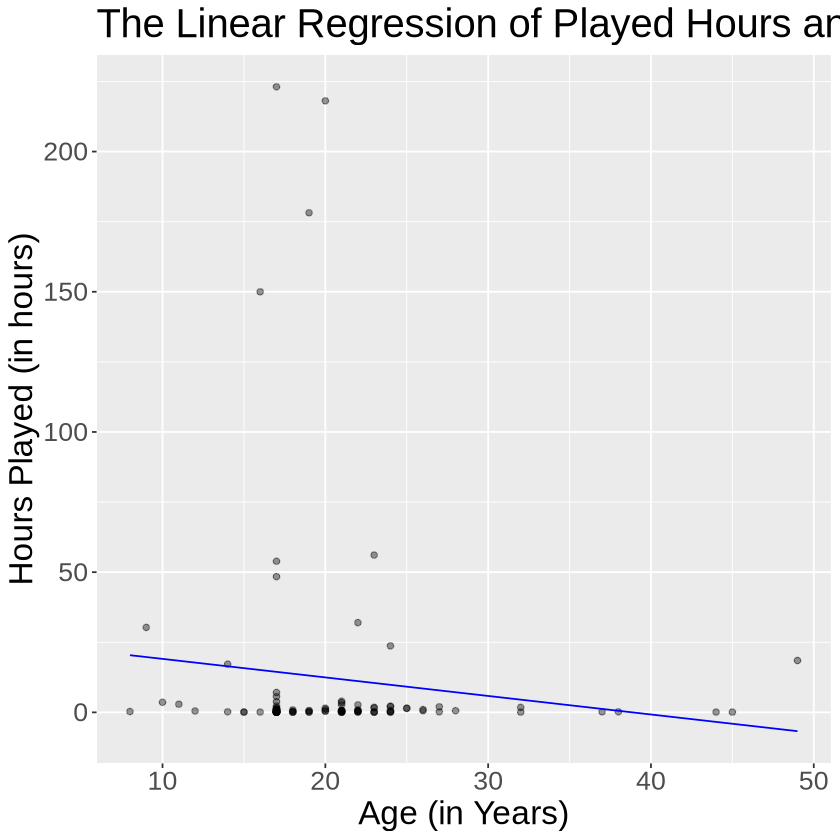

In [119]:
age_plot <- ggplot(player_data_filtered, aes(x = Age, y = played_hours)) +
            geom_point(alpha = 0.4) +
            geom_line(data = players_preds,
                      mapping = aes(x = Age, y = .pred), 
                      color = "blue") +
            xlab("Age (in Years)") +
            ylab("Hours Played (in hours)") +
            ggtitle ("The Linear Regression of Played Hours and Age") +
            theme(text = element_text(size = 20))
age_plot

The linear regression plot above is going downward, showing as age of the players increase, the hours played by the players decrease. 

In [121]:
players_split <- initial_split (player_data_filtered, prop=0.75, strata=played_hours)
training_players <- training(players_split)
testing_players <- testing (players_split)
training_players
testing_players

experience,subscribe,played_hours,gender,Age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.1,Male,17
Regular,TRUE,0.3,Male,8
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,2.1,Male,24
Amateur,TRUE,32.0,Male,22
Amateur,FALSE,2.3,Male,17


experience,subscribe,played_hours,gender,Age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Amateur,TRUE,0.7,Female,21
Amateur,TRUE,0.2,Male,22
Amateur,TRUE,0.5,Male,17
⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,0.1,Non-binary,17
Amateur,TRUE,0.8,Female,22
Veteran,TRUE,0.1,Female,44


In [122]:
players_spec <- linear_reg()|>
            set_engine ("lm") |>
            set_mode ("regression")

players_recipe <- recipe (played_hours~gender, data = training_players)

players_fit <- workflow()|>
            add_recipe (players_recipe)|>
            add_model (players_spec) |>
            fit (data = training_players)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
            (Intercept)             genderFemale  genderPrefer not to say  
                  4.288                   25.566                   -3.468  
       genderNon-binary  
                 51.187  


In [102]:
players_test_result <- players_fit |>
                    predict (testing_players) |>
                    bind_cols (testing_players) 
players_test_result

.pred,experience,subscribe,played_hours,gender,Age
<dbl>,<fct>,<lgl>,<dbl>,<fct>,<dbl>
7.505357,Veteran,TRUE,3.8,Male,17
10.893333,Veteran,TRUE,1.6,Female,23
10.893333,Amateur,TRUE,48.4,Female,17
⋮,⋮,⋮,⋮,⋮,⋮
10.893333,Amateur,TRUE,0.8,Female,22
7.505357,Veteran,FALSE,0.3,Male,22
7.505357,Amateur,FALSE,2.3,Male,17


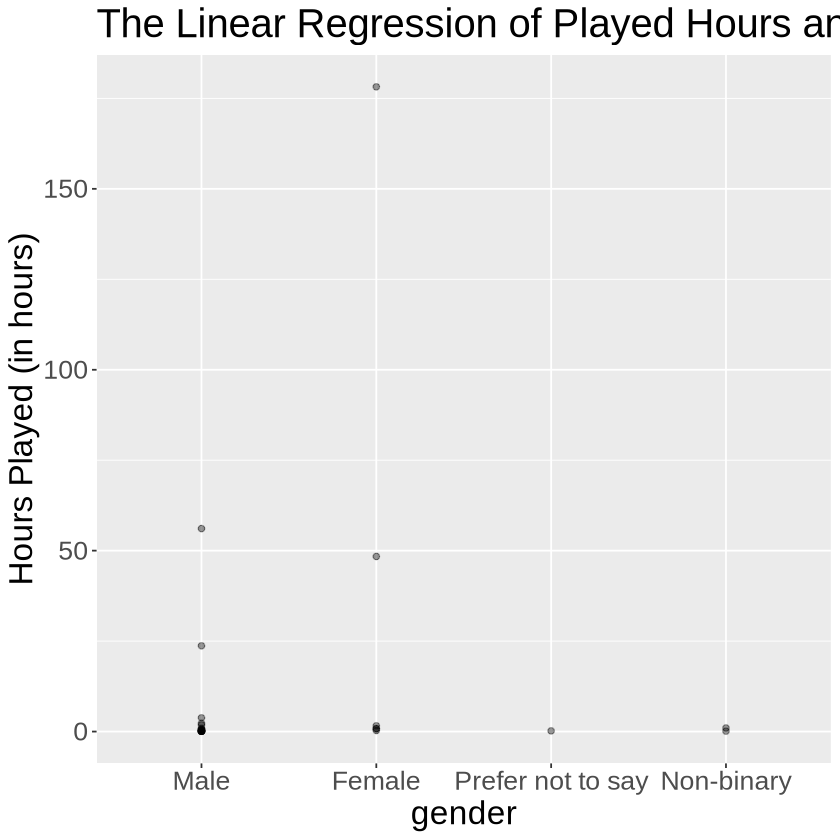

In [103]:
gender_plot <- ggplot(players_test_result, aes(x = gender, y = played_hours)) +
            geom_point(alpha = 0.4) +
            geom_line(aes (y = .pred), 
                      color = "blue") +
            xlab("gender") +
            ylab("Hours Played (in hours)") +
            ggtitle ("The Linear Regression of Played Hours and gender") +
            theme(text = element_text(size = 20))
gender_plot